Imports

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc

In [12]:
df = pd.read_csv("Fraud.csv")
print("Shape:", df.shape)
df.head()

Shape: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [13]:
print(df.isnull().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [14]:
for col in df.columns:
    unique_vals = df[col].nunique()
    print(f"{col}: {unique_vals} unique values")

step: 743 unique values
type: 5 unique values
amount: 5316900 unique values
nameOrig: 6353307 unique values
oldbalanceOrg: 1845844 unique values
newbalanceOrig: 2682586 unique values
nameDest: 2722362 unique values
oldbalanceDest: 3614697 unique values
newbalanceDest: 3555499 unique values
isFraud: 2 unique values
isFlaggedFraud: 2 unique values


In [15]:
merchant_sender = df["nameOrig"].str.startswith("M").sum()
customer_sender = df["nameOrig"].str.startswith("C").sum()

print("Sender Accounts:")
print("Merchants:", merchant_sender)
print("Customers:", customer_sender)

# Count for receiver accounts
merchant_receiver = df["nameDest"].str.startswith("M").sum()
customer_receiver = df["nameDest"].str.startswith("C").sum()

print("\nReceiver Accounts:")
print("Merchants:", merchant_receiver)
print("Customers:", customer_receiver)

Sender Accounts:
Merchants: 0
Customers: 6362620

Receiver Accounts:
Merchants: 2151495
Customers: 4211125


In [16]:
# Create merchant flag
df["isMerchant"] = df["nameDest"].str.startswith("M").astype(int)

# Fraud counts grouped by merchant/customer
fraud_stats = df.groupby("isMerchant")[["isFraud", "isFlaggedFraud"]].sum()
total_counts = df["isMerchant"].value_counts()

fraud_stats["Total_Transactions"] = total_counts
fraud_stats["Fraud_%"] = (fraud_stats["isFraud"] / fraud_stats["Total_Transactions"]) * 100
fraud_stats["Flagged_%"] = (fraud_stats["isFlaggedFraud"] / fraud_stats["Total_Transactions"]) * 100

print(fraud_stats)


            isFraud  isFlaggedFraud  Total_Transactions   Fraud_%  Flagged_%
isMerchant                                                                  
0              8213              16             4211125  0.195031    0.00038
1                 0               0             2151495  0.000000    0.00000


In [17]:
# Filter fraud cases
fraud_cases = df[df["isFraud"] == 1]

# Count fraud transactions by type
fraud_by_type = fraud_cases["type"].value_counts()

print(fraud_by_type)


type
CASH_OUT    4116
TRANSFER    4097
Name: count, dtype: int64


ML MODELS

In [18]:
from sklearn.model_selection import train_test_split

X = df[['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 
        'oldbalanceDest', 'newbalanceDest']]
y = df['isFraud']

# Encode 'type' (categorical → numerical)
X = pd.get_dummies(X, columns=['type'], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
# Handle imbalance
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]


In [19]:
model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss'
)

model.fit(X_train, y_train)

d:\projects\fraud_transaction_detection\venv\lib\site-packages\xgboost\training.py:183: UserWarning: [11:44:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


ROC-AUC Score: 0.9994838480028728

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.33      0.99      0.50      2464

    accuracy                           1.00   1908786
   macro avg       0.67      0.99      0.75   1908786
weighted avg       1.00      1.00      1.00   1908786



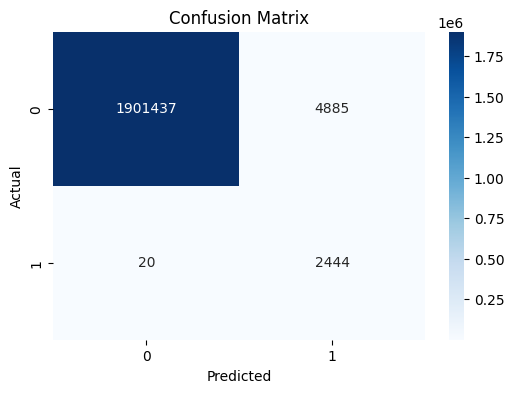

In [20]:
# y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)  

# ROC-AUC Score
auc = roc_auc_score(y_test, y_pred_proba)
print("ROC-AUC Score:", auc)

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [21]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--')  # baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Fraud Detection")
plt.legend()
plt.show()

NameError: name 'roc_curve' is not defined

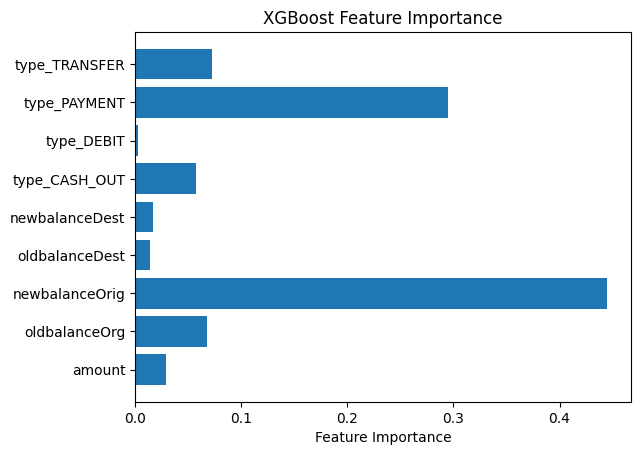

In [22]:
# Feature Importance
importances = model.feature_importances_
features = X.columns
plt.barh(features, importances)
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance")
plt.show()

In [23]:
import joblib
joblib.dump(model, "xgb_fraud_model3.pkl")
print("✅ Model saved as xgb_fraud_model3.pkl")

✅ Model saved as xgb_fraud_model3.pkl


Testing with synthetically created dataset

In [27]:
import numpy as np
import pandas as pd

def generate_paysim_like(n=200_000, fraud_ratio=0.003, seed=7):
    """
    PaySim-like synthetic data with:
      - Only TRANSFER/CASH_OUT eligible for fraud
      - Transaction arithmetic preserved
      - Rare fraud prevalence (default 0.3%)
    Returns: DataFrame, realized fraud ratio
    """
    rng = np.random.default_rng(seed)
    types = np.array(["CASH_IN", "CASH_OUT", "DEBIT", "PAYMENT", "TRANSFER"])
    # Roughly PaySim-ish mix (not exact, but realistic)
    p = np.array([0.27, 0.36, 0.01, 0.27, 0.09])
    tx_type = rng.choice(types, size=n, p=p)

    # Amounts: heavy-tailed
    amount = np.clip(rng.lognormal(mean=8.0, sigma=1.0, size=n), 1, 1_000_000).round(2)

    # Origin balances: usually >= amount, with spread and some insufficiency cases
    budget_factor = np.clip(rng.normal(1.3, 0.5, size=n), 0.0, 5.0)
    oldbalanceOrg = (amount * budget_factor + rng.gamma(2.0, 300.0, size=n)).round(2)

    # Destination balances: many non-zero, some empty (suspicious)
    empty_dest = rng.random(n) < 0.10
    dest_base = rng.gamma(2.0, 300.0, size=n)
    oldbalanceDest = np.where(empty_dest, 0.0, dest_base).round(2)

    # Directionality
    is_out = np.isin(tx_type, ["CASH_OUT", "TRANSFER", "PAYMENT", "DEBIT"])
    is_in  = (tx_type == "CASH_IN")

    can_pay = oldbalanceOrg >= amount
    newbalanceOrig = np.where(is_out & can_pay, oldbalanceOrg - amount,
                        np.where(is_out & ~can_pay, 0.0, oldbalanceOrg))
    newbalanceDest = np.where(is_in, oldbalanceDest + amount, oldbalanceDest)

    # Small noise to avoid perfect determinism
    noise_o = rng.normal(0, 1.0, size=n)
    noise_d = rng.normal(0, 1.0, size=n)
    newbalanceOrig = np.clip(newbalanceOrig + (is_out * noise_o), 0.0, None).round(2)
    newbalanceDest = np.clip(newbalanceDest + (is_in  * noise_d), 0.0, None).round(2)

    # Fraud propensity (only for TRANSFER/CASH_OUT)
    is_transfer = (tx_type == "TRANSFER")
    is_cashout  = (tx_type == "CASH_OUT")
    allow_fraud = (is_transfer | is_cashout)

    eps = 1e-6
    amt_ratio = amount / (oldbalanceOrg + eps)
    drained_orig = (newbalanceOrig == 0.0) & is_out

    # Low baseline, bump on suspicious patterns
    base_logit = -9.0   # keeps base prob tiny
    logit = (base_logit
             + 3.2 * allow_fraud.astype(float)
             + 1.8 * np.clip(amt_ratio - 0.8, 0, None)     # large relative spend
             + 1.0 * drained_orig.astype(float)
             + 0.9 * (empty_dest & is_transfer).astype(float)
             + 0.7 * (amount > 150_000).astype(float))

    # Zero out non-eligible types
    logit = np.where(allow_fraud, logit, -25.0)
    prob = 1 / (1 + np.exp(-logit))

    # Enforce target prevalence by percentile cut
    k = int(round(n * fraud_ratio))
    effective_prob = np.where(allow_fraud, prob, 0.0)
    thresh = np.quantile(effective_prob, 1 - (k / n)) if 0 < k < n else np.inf
    isFraud = (effective_prob >= thresh).astype(int)
    isFlaggedFraud = ((is_transfer) & (amount > 200_000)).astype(int)

    df = pd.DataFrame({
        "type": tx_type,
        "amount": amount,
        "oldbalanceOrg": oldbalanceOrg,
        "newbalanceOrig": newbalanceOrig,
        "oldbalanceDest": oldbalanceDest,
        "newbalanceDest": newbalanceDest,
        "isFraud": isFraud,
        "isFlaggedFraud": isFlaggedFraud
    })

    return df, float(df.isFraud.mean())

# Example: 100k rows, ~0.3% fraud
df_syn, realized = generate_paysim_like(n=100_000, fraud_ratio=0.003, seed=11)
print(df_syn.shape, "fraud_ratio_realized:", round(realized, 5))
df_syn.head()
df_syn.to_csv("test1.csv", index=False)

(100000, 8) fraud_ratio_realized: 0.003


In [38]:
import pandas as pd
import joblib

# 1. Load the saved model
model = joblib.load("xgb_fraud_model3.pkl")

# 2. Load test dataset
df_test = pd.read_csv("test1.csv")


In [39]:
print(df_test.columns)

Index(['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFraud', 'isFlaggedFraud'],
      dtype='object')


Confusion Matrix:
 [[91445  8255]
 [  257    43]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96     99700
           1       0.01      0.14      0.01       300

    accuracy                           0.91    100000
   macro avg       0.50      0.53      0.48    100000
weighted avg       0.99      0.91      0.95    100000



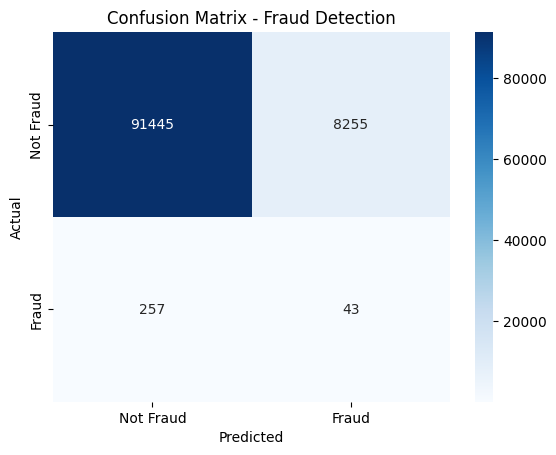

In [40]:
X_test = df_test[['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
                  'oldbalanceDest', 'newbalanceDest']]
y_test = df_test["isFraud"]

# Encode 'type' same as training
X_test = pd.get_dummies(X_test, columns=['type'], drop_first=True)

# --- Ensure same columns as training ---
for col in model.get_booster().feature_names:
    if col not in X_test.columns:
        X_test[col] = 0
X_test = X_test[model.get_booster().feature_names]

# 4. Predictions
y_pred = model.predict(X_test)

# 5. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 6. Optional: Plot heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Fraud", "Fraud"],
            yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Fraud Detection")
plt.show()

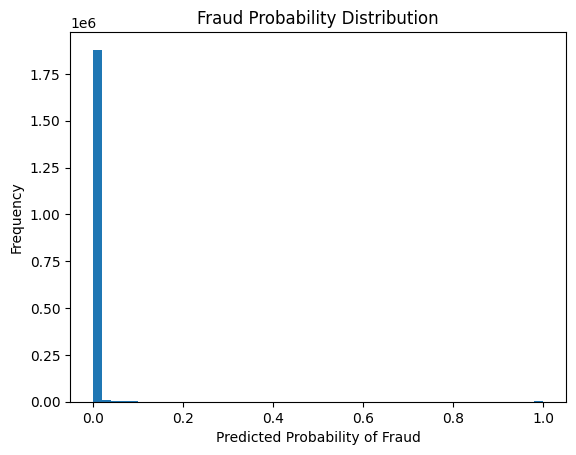

In [79]:
import matplotlib.pyplot as plt

plt.hist(y_pred_proba, bins=50)
plt.title("Fraud Probability Distribution")
plt.xlabel("Predicted Probability of Fraud")
plt.ylabel("Frequency")
plt.show()


In [35]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, average_precision_score

# Load model you trained on PaySim
model = joblib.load("xgb_fraud_model3.pkl")

# Prepare features to match training
X_test = df_syn[['type','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']].copy()
y_test = df_syn['isFraud'].values

# One-hot like training
X_test = pd.get_dummies(X_test, columns=['type'], drop_first=True)

# Align columns to the booster’s feature names
need_cols = model.get_booster().feature_names
for c in need_cols:
    if c not in X_test.columns:
        X_test[c] = 0
X_test = X_test[need_cols]

# Predict proba and get baseline metrics
y_proba = model.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_proba)
ap  = average_precision_score(y_test, y_proba)  # PR-AUC (AP)
print(f"ROC-AUC: {auc:.4f} | PR-AUC (AP): {ap:.4f}")

# Default 0.5 threshold (not recommended for rare fraud; just to see)
y_pred_05 = (y_proba >= 0.5).astype(int)
print(classification_report(y_test, y_pred_05, digits=4))
print(confusion_matrix(y_test, y_pred_05))


ROC-AUC: 0.8590 | PR-AUC (AP): 0.0107
              precision    recall  f1-score   support

           0     0.9972    0.9172    0.9555     99700
           1     0.0052    0.1433    0.0100       300

    accuracy                         0.9149    100000
   macro avg     0.5012    0.5303    0.4828    100000
weighted avg     0.9942    0.9149    0.9527    100000

[[91445  8255]
 [  257    43]]


UPDATED XGBOOST PIPELINE

In [59]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    roc_auc_score, average_precision_score, classification_report,
    confusion_matrix, f1_score
)

# ---------- 0) Config ----------
CSV_PATH = r"D:\projects\fraud_transaction_detection\Fraud.csv"
RANDOM_STATE = 42
TRAIN_FRAC, VAL_FRAC, TEST_FRAC = 0.70, 0.15, 0.15  # temporal split

# ---------- 1) Load ----------
df = pd.read_csv(CSV_PATH)

# ---------- 2) Scope to where PaySim fraud actually occurs ----------
df = df[df["type"].isin(["TRANSFER", "CASH_OUT"])].copy()
df["orig_prefix"] = df["nameOrig"].astype(str).str[0]
df["dest_prefix"] = df["nameDest"].astype(str).str[0]
df["orig_dest"]   = df["orig_prefix"] + "-" + df["dest_prefix"]
df = df[df["orig_dest"] == "C-C"].copy()

# ---------- 3) Feature engineering ----------
eps = 1e-6
df["amt_over_orig"] = df["amount"] / (df["oldbalanceOrg"] + eps)
df["amt_over_dest"] = df["amount"] / (df["oldbalanceDest"] + eps)
df["delta_orig"] = df["oldbalanceOrg"] - df["newbalanceOrig"] - df["amount"]
df["delta_dest"] = df["newbalanceDest"] - df["oldbalanceDest"] - df["amount"]
df["orig_error"] = (df["delta_orig"].abs() > 0.01).astype(int)
df["dest_error"] = (df["delta_dest"].abs() > 0.01).astype(int)
df["drained_orig"] = ((df["newbalanceOrig"] <= 0.01) & (df["oldbalanceOrg"] > 0)).astype(int)
df["empty_dest"]   = (df["oldbalanceDest"] <= 0.01).astype(int)

def step_bucket(h):
    if h < 24: return "lt_1d"
    if h < 24*7: return "lt_1w"
    if h < 24*31: return "lt_1m"
    return "ge_1m"
df["step_bucket"] = df["step"].apply(step_bucket)

# ---------- 4) Define features/target ----------
target = "isFraud"
features_num = [
    "amount","oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest",
    "amt_over_orig","amt_over_dest","delta_orig","delta_dest",
    "orig_error","dest_error","drained_orig","empty_dest"
]
features_cat = ["type","step_bucket","orig_dest"]  # categorical

df = df.sort_values("step").reset_index(drop=True)
n = len(df)
cut1 = int(n * TRAIN_FRAC)
cut2 = int(n * (TRAIN_FRAC + VAL_FRAC))

train_df = df.iloc[:cut1].copy()
val_df   = df.iloc[cut1:cut2].copy()
test_df  = df.iloc[cut2:].copy()

X_train_df, y_train = train_df[features_num + features_cat], train_df[target].astype(int).values
X_val_df,   y_val   = val_df[features_num + features_cat],   val_df[target].astype(int).values
X_test_df,  y_test  = test_df[features_num + features_cat],  test_df[target].astype(int).values

# ---------- 5) Preprocess: OneHotEncoder -> numeric arrays ----------
# Use sparse_output for sklearn >=1.4, fall back to sparse for older versions
import sklearn
ohe_kwargs = dict(handle_unknown="ignore")
if tuple(int(x) for x in sklearn.__version__.split(".")[:2]) >= (1,4):
    ohe_kwargs["sparse_output"] = False
else:
    ohe_kwargs["sparse"] = False

ct = ColumnTransformer(
    transformers=[("ohe", OneHotEncoder(**ohe_kwargs), features_cat)],
    remainder="passthrough"
)

ct.fit(X_train_df)
X_train = ct.transform(X_train_df)   # numpy array (float)
X_val   = ct.transform(X_val_df)
X_test  = ct.transform(X_test_df)

# ---------- 6) Model ----------
neg, pos = np.bincount(y_train)
scale_pos_weight = (neg / max(pos, 1)) if pos > 0 else 1.0

# For xgboost>=2.0, put early_stopping and verbose into constructor or use callbacks
xgb = XGBClassifier(
    n_estimators=3000,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=4,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    objective="binary:logistic",
    eval_metric="aucpr",
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_STATE,
    tree_method="hist",
    early_stopping_rounds=150,
    verbose=False
)

# Fit with transformed eval set
xgb.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)]
)

# ---------- 7) Evaluate on test ----------
y_proba = xgb.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)
pr_auc  = average_precision_score(y_test, y_proba)
print(f"[TEST] ROC-AUC: {roc_auc:.6f} | PR-AUC(AP): {pr_auc:.6f}")

# Max-F1 threshold
best_f1, best_thr = 0.0, 0.5
for t in np.linspace(0.001, 0.20, 400):
    f1 = f1_score(y_test, (y_proba >= t).astype(int), zero_division=0)
    if f1 > best_f1:
        best_f1, best_thr = f1, t

y_pred_f1 = (y_proba >= best_thr).astype(int)
print(f"\n[TEST] Max-F1={best_f1:.4f} at threshold={best_thr:.4f}")
print(classification_report(y_test, y_pred_f1, digits=4))
print("Confusion Matrix (max-F1):\n", confusion_matrix(y_test, y_pred_f1))

# Top-k alert budget example (0.20%)
def labels_by_topk(probas, top_rate=0.002):
    n = len(probas)
    k = max(1, int(n * top_rate))
    thr = np.partition(probas, -k)[-k]
    return (probas >= thr).astype(int), float(thr)

y_pred_k, thr_k = labels_by_topk(y_proba, top_rate=0.002)
print(f"\n[TEST] Top-0.20% alerts (thr={thr_k:.6f})")
print(classification_report(y_test, y_pred_k, digits=4))
print("Confusion Matrix (top-k):\n", confusion_matrix(y_test, y_pred_k))


[0]	validation_0-aucpr:1.00000
[1]	validation_0-aucpr:1.00000


d:\projects\fraud_transaction_detection\venv\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:15:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[2]	validation_0-aucpr:1.00000
[3]	validation_0-aucpr:1.00000
[4]	validation_0-aucpr:1.00000
[5]	validation_0-aucpr:1.00000
[6]	validation_0-aucpr:1.00000
[7]	validation_0-aucpr:1.00000
[8]	validation_0-aucpr:1.00000
[9]	validation_0-aucpr:1.00000
[10]	validation_0-aucpr:1.00000
[11]	validation_0-aucpr:1.00000
[12]	validation_0-aucpr:1.00000
[13]	validation_0-aucpr:1.00000
[14]	validation_0-aucpr:1.00000
[15]	validation_0-aucpr:1.00000
[16]	validation_0-aucpr:1.00000
[17]	validation_0-aucpr:1.00000
[18]	validation_0-aucpr:1.00000
[19]	validation_0-aucpr:1.00000
[20]	validation_0-aucpr:1.00000
[21]	validation_0-aucpr:1.00000
[22]	validation_0-aucpr:1.00000
[23]	validation_0-aucpr:1.00000
[24]	validation_0-aucpr:1.00000
[25]	validation_0-aucpr:1.00000
[26]	validation_0-aucpr:1.00000
[27]	validation_0-aucpr:1.00000
[28]	validation_0-aucpr:1.00000
[29]	validation_0-aucpr:1.00000
[30]	validation_0-aucpr:1.00000
[31]	validation_0-aucpr:1.00000
[32]	validation_0-aucpr:1.00000
[33]	validation_

d:\projects\fraud_transaction_detection\venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\projects\fraud_transaction_detection\venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\projects\fraud_transaction_detection\venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

In [62]:
# =========================
# XGBoost — PaySim (no leakage: pre-transaction features only)
# =========================
import numpy as np
import pandas as pd
import sklearn
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    roc_auc_score, average_precision_score, classification_report,
    confusion_matrix, f1_score
)

CSV_PATH = r"D:\projects\fraud_transaction_detection\Fraud.csv"
RANDOM_STATE = 42
TRAIN_FRAC, VAL_FRAC, TEST_FRAC = 0.70, 0.15, 0.15

# 1) Load
df = pd.read_csv(CSV_PATH)

# 2) Scope to where fraud actually occurs
df = df[df["type"].isin(["TRANSFER", "CASH_OUT"])].copy()
df["orig_prefix"] = df["nameOrig"].astype(str).str[0]
df["dest_prefix"] = df["nameDest"].astype(str).str[0]
df["orig_dest"]   = df["orig_prefix"] + "-" + df["dest_prefix"]
df = df[df["orig_dest"] == "C-C"].copy()

# 3) Pre-transaction features ONLY (no newbalance*, no deltas, no error flags)
def step_bucket(h):
    if h < 24: return "lt_1d"
    if h < 24*7: return "lt_1w"
    if h < 24*31: return "lt_1m"
    return "ge_1m"
df["step_bucket"] = df["step"].apply(step_bucket)

# target & features
target = "isFraud"
features_num = ["amount", "oldbalanceOrg", "oldbalanceDest"]
features_cat = ["type", "step_bucket", "orig_dest"]  # categorical

# 4) Temporal split
df = df.sort_values("step").reset_index(drop=True)
n = len(df); cut1 = int(n*TRAIN_FRAC); cut2 = int(n*(TRAIN_FRAC+VAL_FRAC))
train_df = df.iloc[:cut1].copy()
val_df   = df.iloc[cut1:cut2].copy()
test_df  = df.iloc[cut2:].copy()

X_train_df, y_train = train_df[features_num + features_cat], train_df[target].astype(int).values
X_val_df,   y_val   = val_df[features_num + features_cat],   val_df[target].astype(int).values
X_test_df,  y_test  = test_df[features_num + features_cat],  test_df[target].astype(int).values

# 5) One-hot (version-safe)
ohe_kwargs = dict(handle_unknown="ignore")
if tuple(int(x) for x in sklearn.__version__.split(".")[:2]) >= (1,4):
    ohe_kwargs["sparse_output"] = False
else:
    ohe_kwargs["sparse"] = False

ct = ColumnTransformer(
    transformers=[("ohe", OneHotEncoder(**ohe_kwargs), features_cat)],
    remainder="passthrough"
)
ct.fit(X_train_df)
X_train = ct.transform(X_train_df)
X_val   = ct.transform(X_val_df)
X_test  = ct.transform(X_test_df)

# 6) Model (early stop on VAL)
neg, pos = np.bincount(y_train)
scale_pos_weight = (neg / max(pos,1)) if pos > 0 else 1.0

xgb = XGBClassifier(
    n_estimators=3000,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=4,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    objective="binary:logistic",
    eval_metric="aucpr",
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_STATE,
    tree_method="hist",
    early_stopping_rounds=150
)
xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)])

# 7) Test-set evaluation
y_proba = xgb.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)
pr_auc  = average_precision_score(y_test, y_proba)
print(f"[TEST] ROC-AUC: {roc_auc:.6f} | PR-AUC(AP): {pr_auc:.6f}")

# 8) Threshold: Max-F1
best_f1, best_thr = 0.0, 0.5
for t in np.linspace(0.001, 0.20, 400):
    f1 = f1_score(y_test, (y_proba >= t).astype(int), zero_division=0)
    if f1 > best_f1:
        best_f1, best_thr = f1, t
y_pred_f1 = (y_proba >= best_thr).astype(int)
print(f"\n[TEST] Max-F1={best_f1:.4f} at threshold={best_thr:.4f}")
print(classification_report(y_test, y_pred_f1, digits=4))
print("Confusion Matrix (max-F1):\n", confusion_matrix(y_test, y_pred_f1))

# 9) Threshold: Top-K alert budget (e.g., 0.20%)
def labels_by_topk(probas, top_rate=0.002):
    n = len(probas); k = max(1, int(n * top_rate))
    thr = np.partition(probas, -k)[-k]
    return (probas >= thr).astype(int), float(thr)
y_pred_k, thr_k = labels_by_topk(y_proba, top_rate=0.002)
print(f"\n[TEST] Top-0.20% alerts (thr={thr_k:.6f})")
print(classification_report(y_test, y_pred_k, digits=4))
print("Confusion Matrix (top-k):\n", confusion_matrix(y_test, y_pred_k))


[0]	validation_0-aucpr:0.14347
[1]	validation_0-aucpr:0.31281
[2]	validation_0-aucpr:0.30086
[3]	validation_0-aucpr:0.28269
[4]	validation_0-aucpr:0.39217
[5]	validation_0-aucpr:0.44331
[6]	validation_0-aucpr:0.45344
[7]	validation_0-aucpr:0.46198
[8]	validation_0-aucpr:0.45998
[9]	validation_0-aucpr:0.45402
[10]	validation_0-aucpr:0.45033
[11]	validation_0-aucpr:0.45461
[12]	validation_0-aucpr:0.45992
[13]	validation_0-aucpr:0.47299
[14]	validation_0-aucpr:0.47506
[15]	validation_0-aucpr:0.47676
[16]	validation_0-aucpr:0.47619
[17]	validation_0-aucpr:0.47381
[18]	validation_0-aucpr:0.47643
[19]	validation_0-aucpr:0.47983
[20]	validation_0-aucpr:0.48151
[21]	validation_0-aucpr:0.48031
[22]	validation_0-aucpr:0.48088
[23]	validation_0-aucpr:0.48321
[24]	validation_0-aucpr:0.43363
[25]	validation_0-aucpr:0.43763
[26]	validation_0-aucpr:0.43666
[27]	validation_0-aucpr:0.43832
[28]	validation_0-aucpr:0.56368
[29]	validation_0-aucpr:0.55249
[30]	validation_0-aucpr:0.55548
[31]	validation_0-

In [64]:
# ============================================
# XGBoost — PaySim-style fraud (no leakage)
# Temporal train / val / test + robust threshold selectors
# ============================================
import os
import numpy as np
import pandas as pd
import sklearn
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    roc_auc_score, average_precision_score, classification_report,
    confusion_matrix, f1_score, precision_recall_curve
)

# -------------------
# Config
# -------------------
CSV_PATH = r"D:\projects\fraud_transaction_detection\Fraud.csv"  # <- point to your file
RANDOM_STATE = 42
TRAIN_FRAC, VAL_FRAC, TEST_FRAC = 0.70, 0.15, 0.15

TARGET_RECALL = 0.99      # for high-recall selector
BUDGET_FPR    = 0.005     # 0.5% false positive rate budget
COST_FN       = 10000.0   # cost of a missed fraud (false negative)
COST_FP       = 50.0      # cost of a false alert (false positive)
TOP_RATE      = 0.002     # 0.20% top-k alerting

np.random.seed(RANDOM_STATE)

In [65]:
# -------------------
# Helpers
# -------------------
def step_bucket(h):
    if h < 24: return "lt_1d"
    if h < 24*7: return "lt_1w"
    if h < 24*31: return "lt_1m"
    return "ge_1m"

def version_safe_ohe(features_cat):
    ohe_kwargs = dict(handle_unknown="ignore")
    major, minor = (int(x) for x in sklearn.__version__.split(".")[:2])
    if (major, minor) >= (1, 4):
        ohe_kwargs["sparse_output"] = False
    else:
        ohe_kwargs["sparse"] = False
    return ColumnTransformer(
        transformers=[("ohe", OneHotEncoder(**ohe_kwargs), features_cat)],
        remainder="passthrough"
    )

def show_at_threshold(y_true, y_prob, thr, title=""):
    y_pred = (y_prob >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    print(f"\n[{title}] threshold={thr:.6f}")
    print(classification_report(y_true, y_pred, digits=4))
    print("Confusion Matrix:\n", cm)
    tn, fp, fn, tp = cm.ravel()
    fpr = fp / (fp + tn + 1e-12)
    tpr = tp / (tp + fn + 1e-12)
    prec = tp / (tp + fp + 1e-12)
    print(f"FPR={fpr:.5f} | Recall={tpr:.5f} | Precision={prec:.5f}")
    return cm

def threshold_max_f1(y_true, y_prob, lo=0.001, hi=0.20, steps=400):
    best_f1, best_thr = -1.0, 0.5
    for t in np.linspace(lo, hi, steps):
        f1 = f1_score(y_true, (y_prob >= t).astype(int), zero_division=0)
        if f1 > best_f1:
            best_f1, best_thr = f1, t
    return best_thr, best_f1

def threshold_high_recall_best_precision(y_true, y_prob, target_recall=0.99):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_prob)
    # thresholds has len = len(precisions) - 1
    best = {"prec": -1, "rec": 0, "thr": thresholds[0] if len(thresholds) else 0.5}
    for p, r, t in zip(precisions[:-1], recalls[:-1], thresholds):
        if r >= target_recall and p > best["prec"]:
            best = {"prec": p, "rec": r, "thr": t}
    return best  # dict: thr, rec, prec

def threshold_with_fp_budget(y_true, y_prob, budget_fpr=0.005):
    # Sweep thresholds from high to lower to keep FPs small
    candidates = []
    for thr in np.percentile(y_prob, np.linspace(99.9, 50, 500)):
        y_pred = (y_prob >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        fpr = fp / (fp + tn + 1e-12)
        rec = tp / (tp + fn + 1e-12)
        if fpr <= budget_fpr:
            candidates.append((rec, thr, fpr))
    if not candidates:
        # fall back to extremely high threshold to minimize FPs
        thr = np.percentile(y_prob, 99.99)
        return {"thr": thr, "rec": None, "fpr": None}
    rec, thr, fpr = max(candidates, key=lambda x: x[0])
    return {"thr": thr, "rec": rec, "fpr": fpr}

def threshold_min_expected_cost(y_true, y_prob, cost_fn=10000.0, cost_fp=50.0):
    best = {"thr": 0.5, "cost": np.inf, "tp":0, "fp":0, "fn":0, "tn":0}
    for thr in np.percentile(y_prob, np.linspace(99.9, 0.1, 800)):
        y_pred = (y_prob >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        exp_cost = fn * cost_fn + fp * cost_fp
        if exp_cost < best["cost"]:
            best = {"thr": thr, "cost": exp_cost, "tp":tp, "fp":fp, "fn":fn, "tn":tn}
    return best

def labels_by_topk(probas, top_rate=0.002):
    n = len(probas)
    k = max(1, int(n * top_rate))
    thr = np.partition(probas, -k)[-k]
    return (probas >= thr).astype(int), float(thr)



In [66]:
# -------------------
# 1) Load
# -------------------
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"CSV not found at: {CSV_PATH}")
df = pd.read_csv(CSV_PATH)



In [67]:
# -------------------
# 2) Scope to fraud-eligible traffic
# -------------------
df = df[df["type"].isin(["TRANSFER", "CASH_OUT"])].copy()
df["orig_prefix"] = df["nameOrig"].astype(str).str[0]
df["dest_prefix"] = df["nameDest"].astype(str).str[0]
df["orig_dest"]   = df["orig_prefix"] + "-" + df["dest_prefix"]
df = df[df["orig_dest"] == "C-C"].copy()




In [68]:
# -------------------
# 3) Pre-transaction features ONLY (no leakage)
# -------------------
df["step_bucket"] = df["step"].apply(step_bucket)

target = "isFraud"
features_num = ["amount", "oldbalanceOrg", "oldbalanceDest"]
features_cat = ["type", "step_bucket", "orig_dest"]



In [69]:
# -------------------
# 4) Temporal split
# -------------------
df = df.sort_values("step").reset_index(drop=True)
n = len(df); cut1 = int(n*TRAIN_FRAC); cut2 = int(n*(TRAIN_FRAC+VAL_FRAC))
train_df = df.iloc[:cut1].copy()
val_df   = df.iloc[cut1:cut2].copy()
test_df  = df.iloc[cut2:].copy()

X_train_df, y_train = train_df[features_num + features_cat], train_df[target].astype(int).values
X_val_df,   y_val   = val_df[features_num + features_cat],   val_df[target].astype(int).values
X_test_df,  y_test  = test_df[features_num + features_cat],  test_df[target].astype(int).values

print(f"Train size: {len(train_df):,} | Val: {len(val_df):,} | Test: {len(test_df):,}")
print("Train class balance:", np.bincount(y_train))



Train size: 1,939,286 | Val: 415,561 | Test: 415,562
Train class balance: [1935653    3633]


In [70]:
# -------------------
# 5) One-hot -> numeric arrays
# -------------------
ct = version_safe_ohe(features_cat)
ct.fit(X_train_df)

X_train = ct.transform(X_train_df)
X_val   = ct.transform(X_val_df)
X_test  = ct.transform(X_test_df)



In [71]:
# -------------------
# 6) Model (early stop on VAL PR-AUC)
# -------------------
neg, pos = np.bincount(y_train)
scale_pos_weight = (neg / max(pos, 1)) if pos > 0 else 1.0
print("scale_pos_weight:", round(scale_pos_weight, 2))

xgb = XGBClassifier(
    n_estimators=3000,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=4,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    objective="binary:logistic",
    eval_metric="aucpr",
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_STATE,
    tree_method="hist",
    early_stopping_rounds=150
)
xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)])



scale_pos_weight: 532.8
[0]	validation_0-aucpr:0.14347
[1]	validation_0-aucpr:0.31281
[2]	validation_0-aucpr:0.30086
[3]	validation_0-aucpr:0.28269
[4]	validation_0-aucpr:0.39217
[5]	validation_0-aucpr:0.44331
[6]	validation_0-aucpr:0.45344
[7]	validation_0-aucpr:0.46198
[8]	validation_0-aucpr:0.45998
[9]	validation_0-aucpr:0.45402
[10]	validation_0-aucpr:0.45033
[11]	validation_0-aucpr:0.45461
[12]	validation_0-aucpr:0.45992
[13]	validation_0-aucpr:0.47299
[14]	validation_0-aucpr:0.47506
[15]	validation_0-aucpr:0.47676
[16]	validation_0-aucpr:0.47619
[17]	validation_0-aucpr:0.47381
[18]	validation_0-aucpr:0.47643
[19]	validation_0-aucpr:0.47983
[20]	validation_0-aucpr:0.48151
[21]	validation_0-aucpr:0.48031
[22]	validation_0-aucpr:0.48088
[23]	validation_0-aucpr:0.48321
[24]	validation_0-aucpr:0.43363
[25]	validation_0-aucpr:0.43763
[26]	validation_0-aucpr:0.43666
[27]	validation_0-aucpr:0.43832
[28]	validation_0-aucpr:0.56368
[29]	validation_0-aucpr:0.55249
[30]	validation_0-aucpr:0.

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,150
,enable_categorical,False
,eval_metric,'aucpr'


In [72]:
# -------------------
# 7) Test-set evaluation (ranking)
# -------------------
y_proba = xgb.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)
pr_auc  = average_precision_score(y_test, y_proba)
print(f"\n[TEST] ROC-AUC: {roc_auc:.6f} | PR-AUC(AP): {pr_auc:.6f}")




[TEST] ROC-AUC: 0.998903 | PR-AUC(AP): 0.937313


In [76]:
# -------------------
# 8) Operating points
# -------------------

# Max-F1
thr_f1, best_f1 = threshold_max_f1(y_test, y_proba, lo=0.001, hi=0.30, steps=600)
show_at_threshold(y_test, y_proba, thr_f1, title=f"Max-F1 (F1={best_f1:.4f})")

# High-recall, best-precision (catch >= target recall)
hr = threshold_high_recall_best_precision(y_test, y_proba, target_recall=TARGET_RECALL)
print(f"\n[High-recall selector] target recall={TARGET_RECALL:.3f} "
      f"-> thr={hr['thr']:.6f}, recall={hr['rec']:.4f}, precision={hr['prec']:.4f}")
show_at_threshold(y_test, y_proba, hr["thr"], title=f"High-Recall ≥{TARGET_RECALL:.0%}")

# FP-budget (limit false alarms among legit)
fpb = threshold_with_fp_budget(y_test, y_proba, budget_fpr=BUDGET_FPR)
print(f"\n[FP-budget selector] budget FPR={BUDGET_FPR:.2%} "
      f"-> thr={fpb['thr']:.6f}, recall={fpb['rec']}, FPR={fpb['fpr']}")
show_at_threshold(y_test, y_proba, fpb["thr"], title=f"FP-budget ≤{BUDGET_FPR:.2%}")

# Cost-based (min expected loss)
costs = threshold_min_expected_cost(y_test, y_proba, cost_fn=COST_FN, cost_fp=COST_FP)
print(f"\n[Cost-based selector] thr={costs['thr']:.6f}, expected cost={costs['cost']:.2f}, "
      f"TP={costs['tp']}, FP={costs['fp']}, FN={costs['fn']}, TN={costs['tn']}")
show_at_threshold(y_test, y_proba, costs["thr"], title="Cost-based minimum")

# Top-K (capacity-driven)
y_pred_k, thr_k = labels_by_topk(y_proba, top_rate=TOP_RATE)
print(f"\n[Top-K alerts] rate={TOP_RATE:.2%} -> thr={thr_k:.6f}")
print(classification_report(y_test, y_pred_k, digits=4))
print("Confusion Matrix (Top-K):\n", confusion_matrix(y_test, y_pred_k))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_k).ravel()
print(f"Top-K Precision={tp/(tp+fp+1e-12):.5f} | Recall={tp/(tp+fn+1e-12):.5f} | FPR={fp/(fp+tn+1e-12):.5f}")


[Max-F1 (F1=0.7254)] threshold=0.300000
              precision    recall  f1-score   support

           0     0.9997    0.9932    0.9964    411542
           1     0.5812    0.9647    0.7254      4020

    accuracy                         0.9929    415562
   macro avg     0.7904    0.9789    0.8609    415562
weighted avg     0.9956    0.9929    0.9938    415562

Confusion Matrix:
 [[408748   2794]
 [   142   3878]]
FPR=0.00679 | Recall=0.96468 | Precision=0.58124

[High-recall selector] target recall=0.990 -> thr=0.030799, recall=0.9900, precision=0.3543

[High-Recall ≥99%] threshold=0.030799
              precision    recall  f1-score   support

           0     0.9999    0.9824    0.9911    411542
           1     0.3543    0.9900    0.5219      4020

    accuracy                         0.9825    415562
   macro avg     0.6771    0.9862    0.7565    415562
weighted avg     0.9937    0.9825    0.9865    415562

Confusion Matrix:
 [[404290   7252]
 [    40   3980]]
FPR=0.01762 | Re